In [40]:
%pip install jmetalpy
%pip install scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\michk\Anaconda3\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\michk\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [41]:
"""
Project:
- Clonal selection immunological algorithm
"""
import numpy as np
from copy import copy
from typing import TypeVar, List
from jmetal.core.algorithm import EvolutionaryAlgorithm
from jmetal.core.operator import Mutation
from jmetal.core.problem import Problem
from jmetal.util.evaluator import Evaluator, SequentialEvaluator
from jmetal.util.generator import Generator, RandomGenerator
from jmetal.util.termination_criterion import TerminationCriterion
from jmetal.util.constraint_handling import overall_constraint_violation_degree

S = TypeVar('S')
R = TypeVar('R')

class CloneAlg(EvolutionaryAlgorithm[S, R]):

    def __init__(self,
                 problem: Problem,
                 population_size: int,
                 offspring_population_size: int,
                 mutation: Mutation,
                 cloning_param: float,
                 termination_criterion: TerminationCriterion,
                 population_generator: Generator = RandomGenerator(),
                 population_evaluator: Evaluator = SequentialEvaluator()):
        super(CloneAlg, self).__init__(
            problem=problem,
            population_size=population_size,
            offspring_population_size=offspring_population_size)
        self.population_size = population_size
        self.offspring_population_size = offspring_population_size

        self.mutation_operator = mutation
        self.cloning_param = cloning_param

        self.population_generator = population_generator
        self.population_evaluator = population_evaluator

        self.termination_criterion = termination_criterion
        self.observable.register(termination_criterion)


    def create_initial_solutions(self) -> List[S]:
        return [self.population_generator.new(self.problem)
                for _ in range(self.population_size)]

    def evaluate(self, solution_list: List[S]):
        return self.population_evaluator.evaluate(solution_list, self.problem)

    def stopping_condition_is_met(self) -> bool:
        return self.termination_criterion.is_met

    def step(self):
        mating_population = self.selection(self.solutions)
        offspring_population = self.reproduction(mating_population)
        offspring_population = self.evaluate(offspring_population)

        self.solutions = self.replacement(self.solutions, offspring_population)

    def selection(self, population: List[S]) -> List[S]:
        return population

    def reproduction(self, population: List[S]) -> List[S]:
        offspring_population = []
        overall_fitness = np.mean([solution.objectives[0] for solution in population])
        for solution in population:
            fitness = solution.objectives[0]
            for j in range(int(self.offspring_population_size * self.cloning_param * (fitness / overall_fitness))): # make clones based on fitness - it could be applied better
                new_solution = copy(solution)
                offspring_population.append(self.mutation_operator.execute(new_solution)) # mutate clones

        return offspring_population

    def replacement(self, population: List[S], offspring_population: List[S]) -> List[S]:
        population_pool = offspring_population

        population_pool.sort(key=lambda s: (overall_constraint_violation_degree(s), s.objectives[0]))

        new_population = []
        for i in range(self.population_size):
            new_population.append(population_pool[i])

        return new_population

    def get_result(self) -> R:
        return self.solutions[0]

    def get_cloning_param(self):
        return self.cloning_param

    def get_name(self) -> str:
        return 'ClonAlg'



In [42]:
from clonalg import CloneAlg
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover, UniformMutation
from jmetal.problem.singleobjective.unconstrained import Rastrigin
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.observer import Observer
from jmetal.operator.selection import RouletteWheelSelection, BestSolutionSelection
from jmetal.core.problem import FloatProblem, FloatSolution
import matplotlib.pyplot as plt
from jmetal.core.operator import Crossover
import scikit_posthocs as sp
from math import sqrt, sin
from scipy import stats
import numpy as np
import math
import random, copy
from typing import List
import seaborn as sns
sns.set()

In [43]:
class Ackle(FloatProblem):
    def __init__(self, number_of_variables: int = 10):
        super().__init__()
        self.number_of_objectives = 1
        self.number_of_variables = number_of_variables
        self.number_of_constraints = 0

        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['f(x)']

        self.lower_bound = [-32.768 for _ in range(number_of_variables)]
        self.upper_bound = [32.768 for _ in range(number_of_variables)]

        FloatSolution.lower_bound = self.lower_bound
        FloatSolution.upper_bound = self.upper_bound

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        n_rev = 1 / solution.number_of_variables
        x = solution.variables
        sum_of_sqr = 0
        sum_of_cos = 0

        for i in range(solution.number_of_variables):
            sum_of_sqr += x[i] * x[i]
            sum_of_cos += math.cos(2 * math.pi * x[i])

        result = -20 * math.exp(-0.2 * math.sqrt(n_rev * sum_of_sqr)) \
                 - math.exp(n_rev * sum_of_cos) + 20 + math.exp(1)

        solution.objectives[0] = result

        return solution

    def get_name(self) -> str:
        return "Ackle's"


In [44]:
class Schwefel(FloatProblem):
    def __init__(self, number_of_variables: int = 10):
        super().__init__()
        self.number_of_objectives = 1
        self.number_of_variables = number_of_variables
        self.number_of_constraints = 0

        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['f(x)']

        self.lower_bound = [-5.12 for _ in range(number_of_variables)]
        self.upper_bound = [5.12 for _ in range(number_of_variables)]

        FloatSolution.lower_bound = self.lower_bound
        FloatSolution.upper_bound = self.upper_bound

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        a = 418.9829
        result = a * solution.number_of_variables
        x = solution.variables

        for i in range(solution.number_of_variables):
            result -= x[i] * sin(sqrt(abs(x[i])))

        solution.objectives[0] = result
        return solution

    def get_name(self) -> str:
        return "Schwefel's"

In [45]:
class DiscreteCrossover(Crossover[FloatSolution, FloatSolution]):
    def __init__(self, probability: float):
        super(DiscreteCrossover, self).__init__(probability=probability)

    def execute(self, parents: List[FloatSolution]) -> List[FloatSolution]:
        if len(parents) != 2:
            raise Exception('The number of parents is: {}, expected: 2'.format(len(parents)))

        offspring = [copy.deepcopy(parents[0]), copy.deepcopy(parents[1])]
        rand = random.random()

        if rand <= self.probability:
            permut_len = offspring[0].number_of_variables
            for i in range(permut_len):
                rand = random.random()
                offspring[0].variables[i] = parents[0].variables[i] if rand <= 0.5 else parents[1].variables[i]
                offspring[1].variables[i] = parents[0].variables[i] if rand > 0.5 else parents[1].variables[i]

        return offspring

    def get_number_of_parents(self) -> int:
        return 2

    def get_number_of_children(self) -> int:
        return 2

    def get_name(self):
        return 'Discrete crossover'

In [46]:
class DataObserver(Observer):

    def __init__(self, frequency: float = 1.0, data = []) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.data = data

    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']

        if (evaluations % self.display_frequency) == 0 and solutions:
            if type(solutions) == list:
                fitness = solutions[0].objectives
            else:
                fitness = solutions.objectives
            self.data.append(fitness[0])


In [47]:
def solve(problem, cloning_param, mutation):
    final_data = []
    final_problem = problem(dim)
    final_mutation = mutation(mut_pb, 20)

    for x in range(repetitions):
        algorithm = CloneAlg(
            problem=final_problem,
            population_size=100,
            offspring_population_size=100,
            mutation=final_mutation,
            cloning_param=cloning_param,
            termination_criterion=StoppingByEvaluations(max_evaluations=500) # get me higher
        )
        data = []
        dataobserver = DataObserver(1.0, data)
        algorithm.observable.register(observer=dataobserver)
        algorithm.run()
        final_data.append(data)

    trans_list = np.array(final_data).T.tolist()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(trans_list)
    plt.title("Problem: {0} benchmark, dim: {1}, cloning_param: {2}, mutation: {3}".format(
        final_problem.get_name(),
        dim,
        algorithm.get_cloning_param(),
        final_mutation.get_name()))
    plt.show()

    # Kruskal-Wallis and Dunn tests
    print(stats.kruskal(trans_list[0], trans_list[1], trans_list[-1]))
    sp.posthoc_dunn([trans_list[0], trans_list[1], trans_list[-1]], p_adjust='holm')



In [48]:
repetitions = 10
dim = 50
mut_pb = 0.8

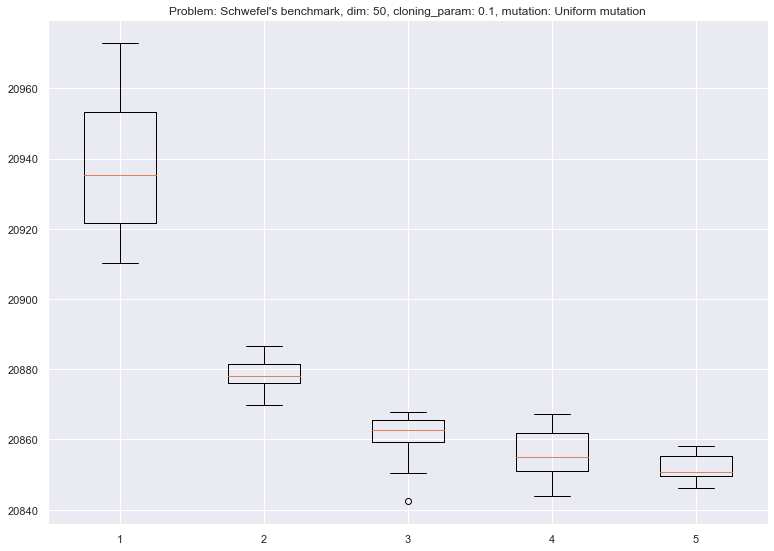

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


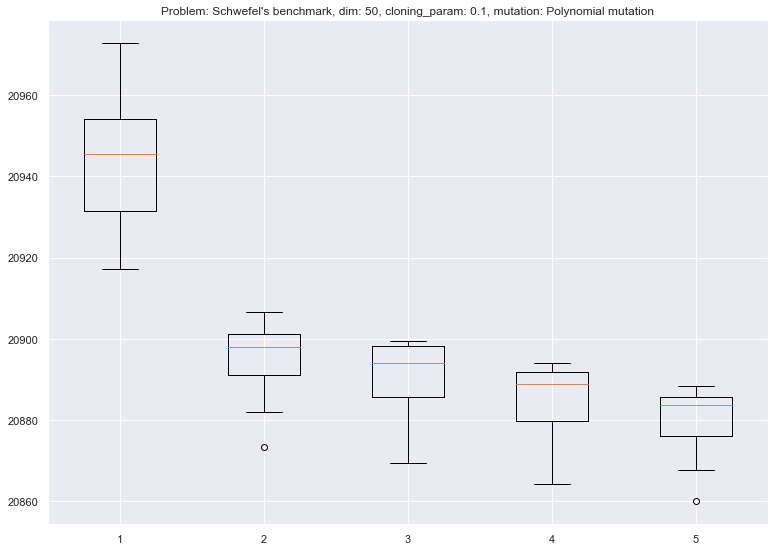

KruskalResult(statistic=22.69935483870968, pvalue=1.1773286846910376e-05)


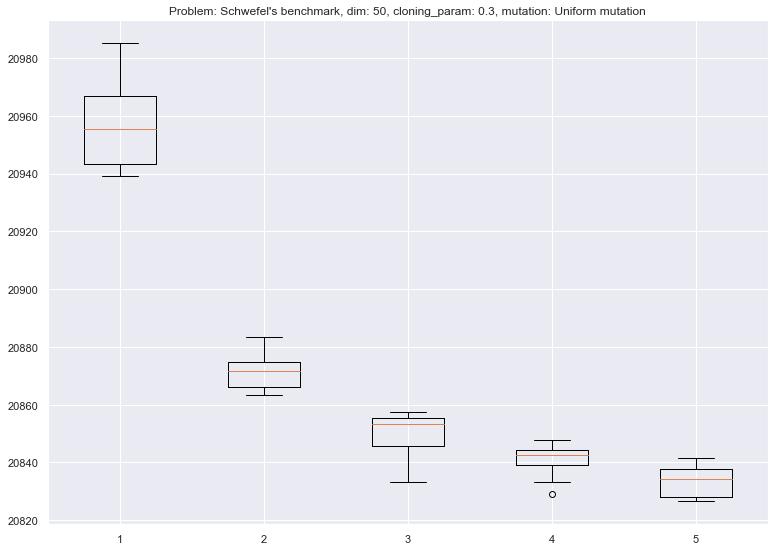

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


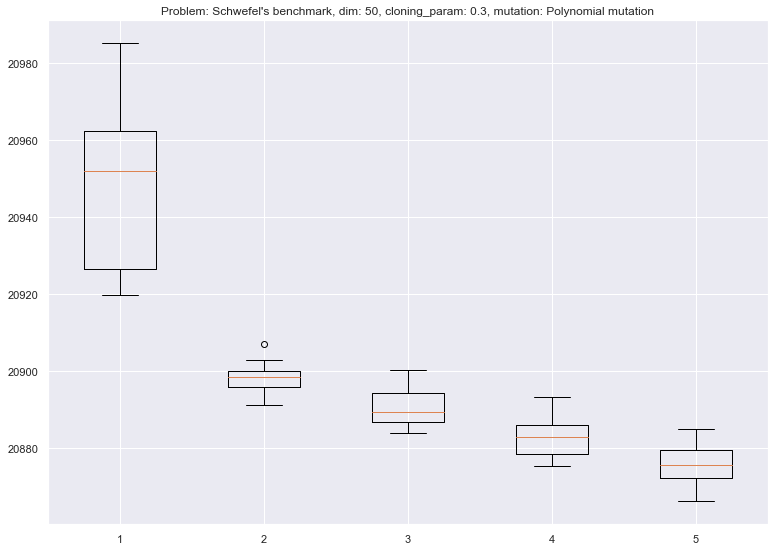

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


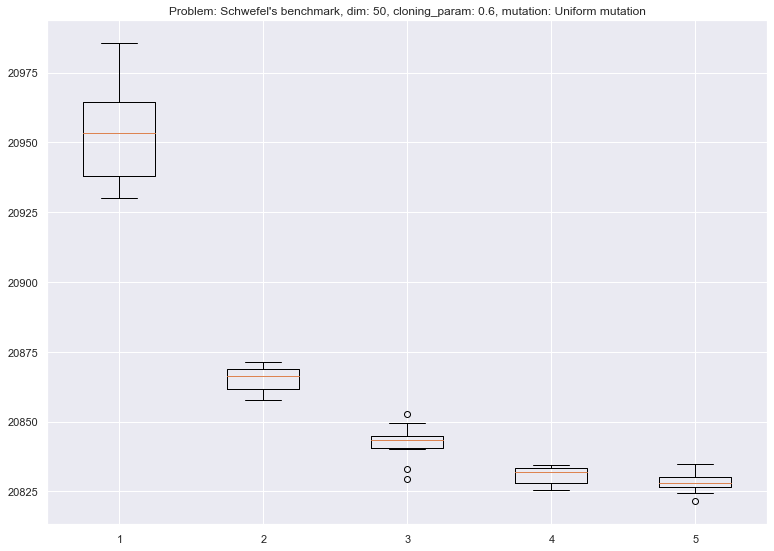

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


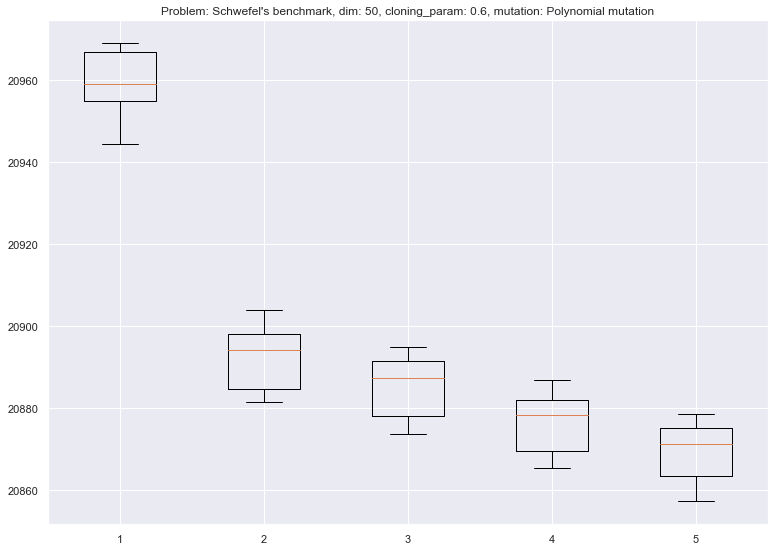

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


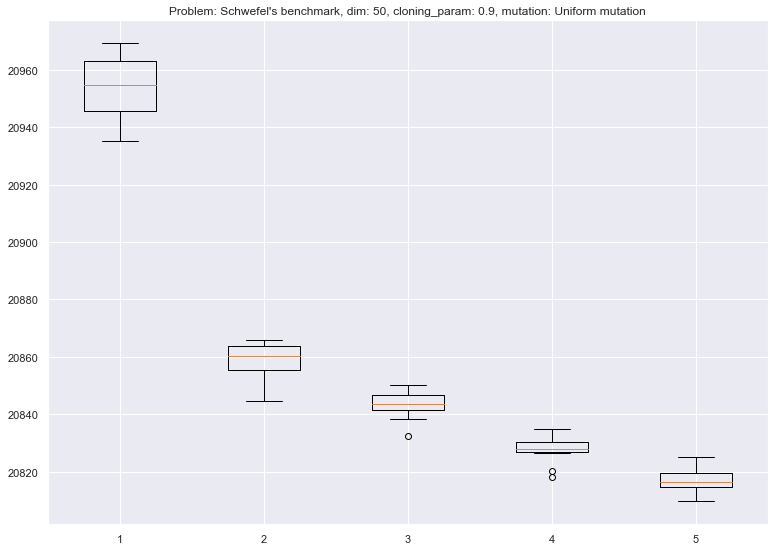

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


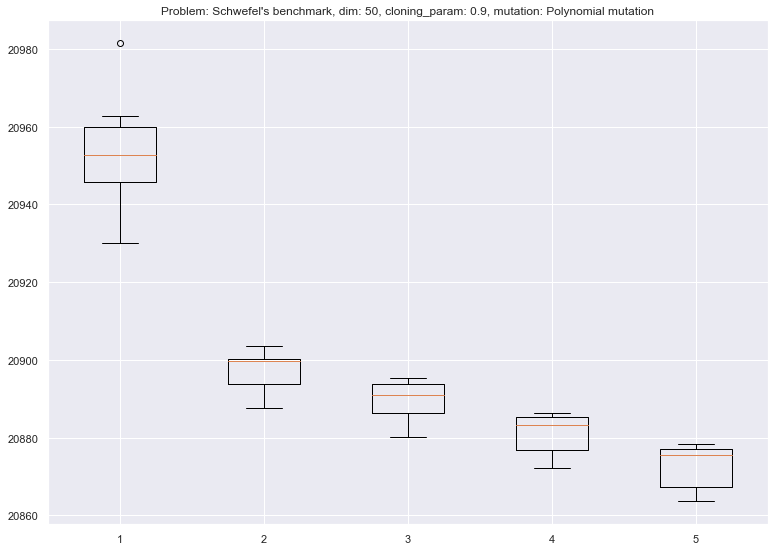

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


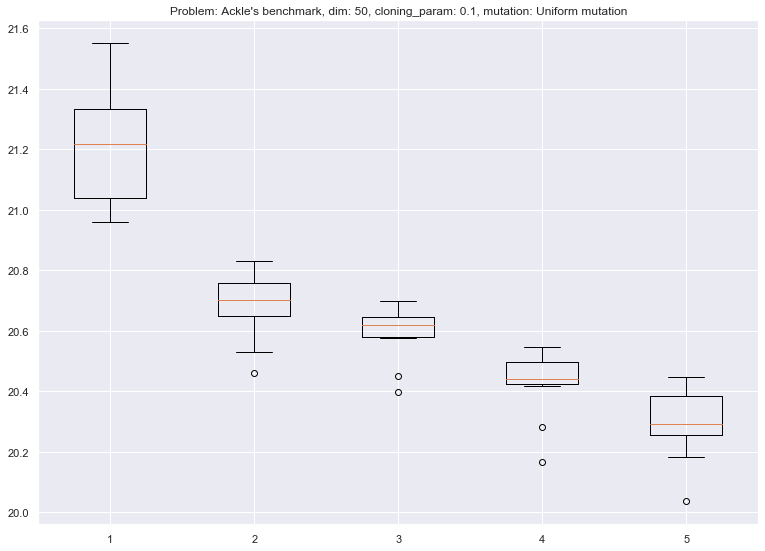

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


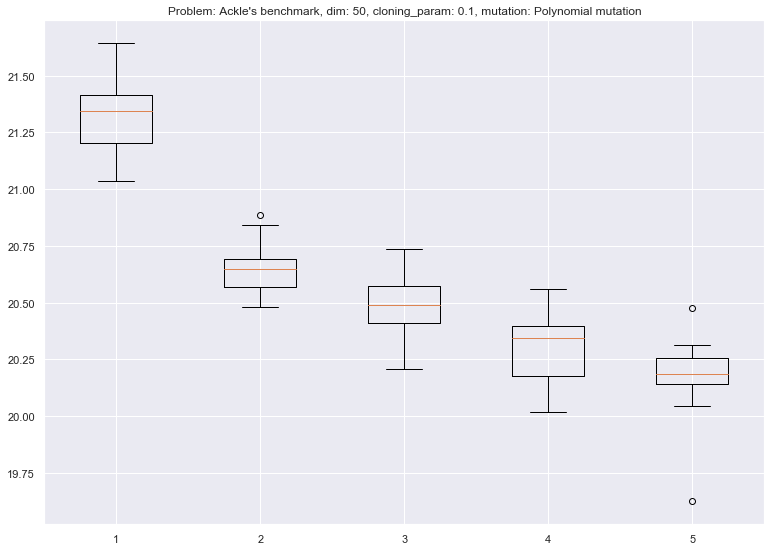

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


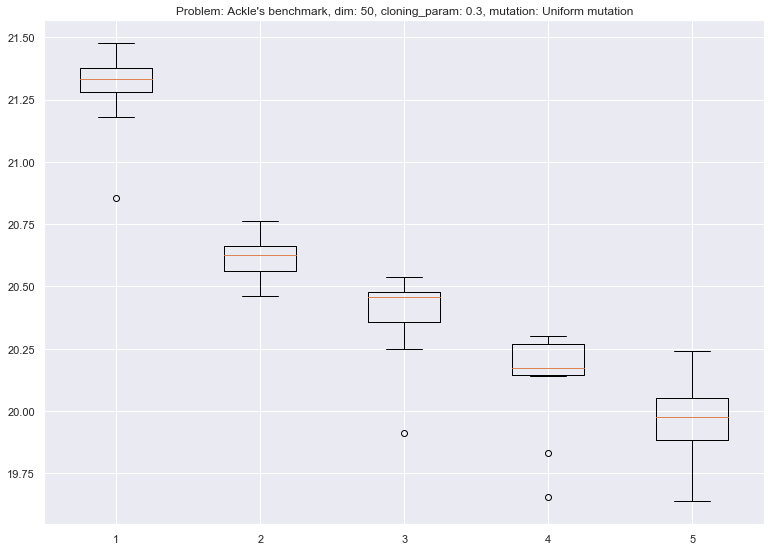

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


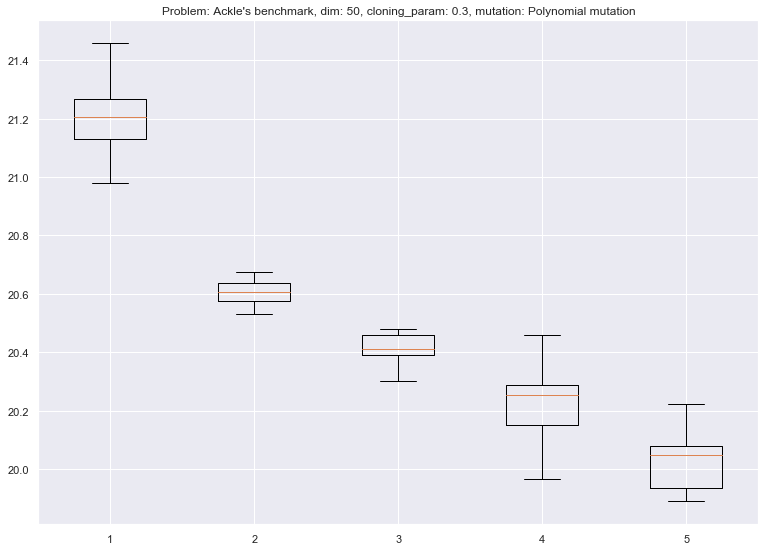

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


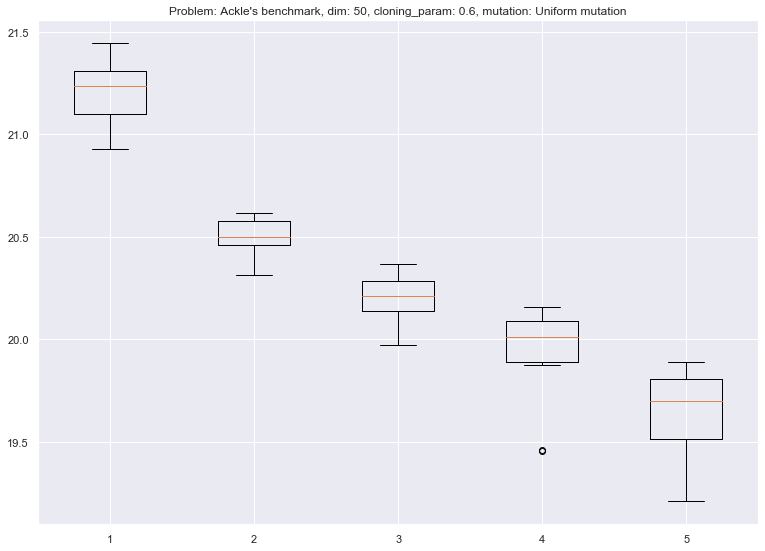

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


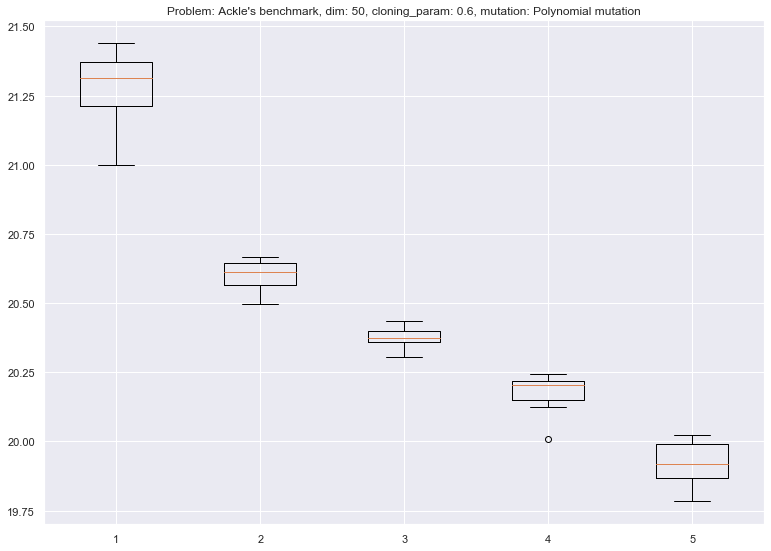

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


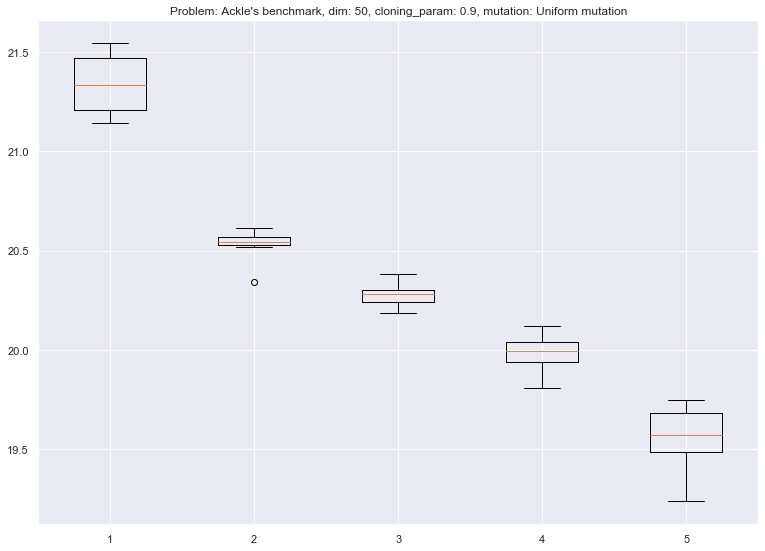

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


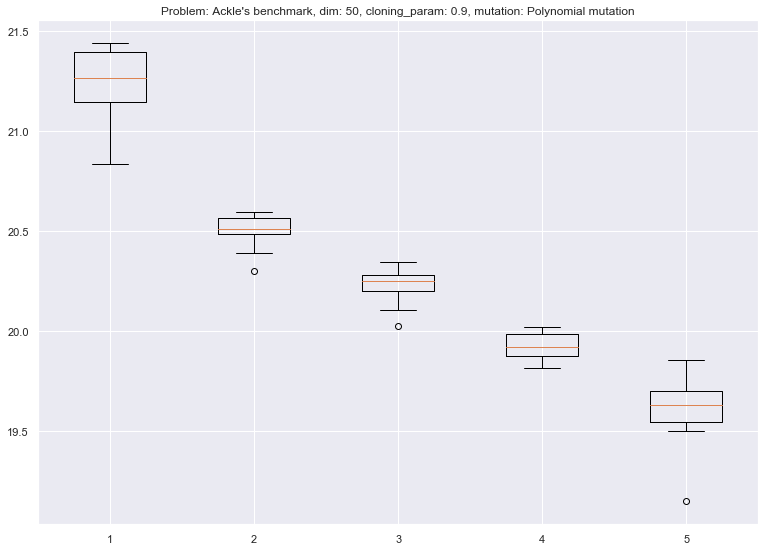

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [49]:
[solve(problem, cloning_param, mutation)
 for problem in [Schwefel, Ackle]
 for cloning_param in [0.1, 0.3, 0.6, 0.9]
 for mutation in [UniformMutation, PolynomialMutation]]